# Example show casing a PCM analysis in the Southern Ocean with Argo data

This is using the [pyXpcm](https://pyxpcm.readthedocs.io) library and pre-processed Argo cloud data

Author: [Guillaume Maze](http://github.com/gmaze)

Data prepared by:  
<div>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" height="100"/>
and <img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="300"/>
</div>

# Set-up

## Install pyXpcm
When ran on binder, this should have been done automatically

In [1]:
# !pip install git+http://github.com/obidam/pyxpcm.git

In [3]:
# Then test the import
import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

pyxpcm: 0.4.0, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/pyxpcm/__init__.py


## Other import

In [2]:
import os
import numpy as np
import xarray as xr
import intake

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['spark_dataframe', 'spark_rdd', 'spark_cat'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [1]:
# Imports for plotting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns # Not mandatory, but create nicer figures

def orsi_fronts(ax, transform=None, colors='k'*20, **args):
    orsi = pyxpcm.tutorial.open_dataset('orsi').load()
    hl = list()
    for ii, front in enumerate(orsi.data_vars):
        path = orsi[front].dropna(dim='point')
        default_opts = {'color': colors[ii], 'linewidth':1, 'transform': transform}
        opts = {**default_opts, **args}
        hl.append(ax.plot(path[0,:], path[1,:], label=path.attrs['long_name'], **opts))
    return hl

# Load Argo data from the cloud

This is a global subset of Argo data with profiles interpolated onto standard depth levels and uniformaly distributed in space.

In [5]:
# Open catalogue:
catalog_url = 'https://raw.githubusercontent.com/obidam/m2poc2019/master/m2poc_data_catalog.yml'
cat = intake.Catalog(catalog_url)
# Load data (lazily):
ds = cat.argo_global_homogeneous_sdl.read_chunked()
ds

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 128910)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE   (N_PROF) float32 dask.array<chunksize=(67010,), meta=np.ndarray>
    LONGITUDE  (N_PROF) float32 dask.array<chunksize=(67010,), meta=np.ndarray>
    TIME       (N_PROF) datetime64[ns] dask.array<chunksize=(64455,), meta=np.ndarray>
Dimensions without coordinates: N_PROF
Data variables:
    BRV2       (N_PROF, DEPTH) float32 dask.array<chunksize=(67010, 302), meta=np.ndarray>
    DBINDEX    (N_PROF) float64 dask.array<chunksize=(67010,), meta=np.ndarray>
    PSAL       (N_PROF, DEPTH) float32 dask.array<chunksize=(67010, 302), meta=np.ndarray>
    SIG0       (N_PROF, DEPTH) float32 dask.array<chunksize=(67010, 302), meta=np.ndarray>
    TEMP       (N_PROF, DEPTH) float32 dask.array<chunksize=(67010, 302), meta=np.ndarray>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
    conventions_help:  

## Sub-sample to a given region: Southern Ocean

In [4]:
ds = ds.where(ds['LATITUDE']<=-20, drop=True)
ds.load()
ds

NameError: name 'ds' is not defined

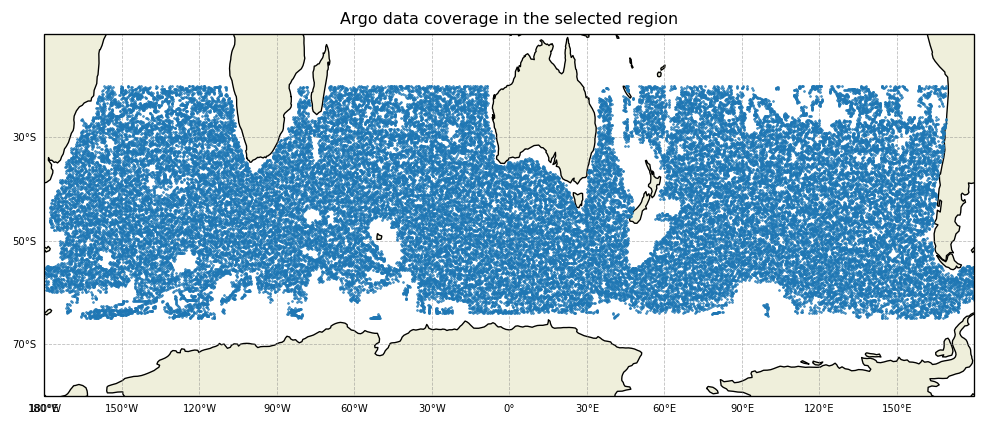

In [7]:
proj = ccrs.PlateCarree(central_longitude=360-60-180)
projref = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-180,180,-70,-15]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
ax.plot(ds['LONGITUDE'], ds['LATITUDE'], '.', transform=projref, markersize=1)
ax.set_aspect(2)
ax.set_extent([-180, 180, -80, -10], projref)
gl = pyxpcm.plot.latlongrid(ax, dx=30, dy=20)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Argo data coverage in the selected region')
plt.show()

# PCM analysis

## Define PCM parameters

In [8]:
# 1/ Features, Define ocean features to classify

# Vertical axis to use:
z = ds['DEPTH'].values

# Dictionnary of feature names with vertical axis:
# pcm_features = {'TEMP': z} # Single feature analysis
pcm_features = {'TEMP': z, 'PSAL':z} # Multi-feature analysis

# 2/ Nb of class, Define how many classes we want
N_CLASS = 8

In [9]:
# Create the classification model
from pyxpcm.models import pcm

# Instantiate a PCM:
m = pcm(K=N_CLASS, features=pcm_features, backend='sklearn')
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['TEMP', 'PSAL'])
Fitted: False
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'PSAL'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

## Fit/predict classes

In [10]:
%%time
m.fit_predict(ds, inplace=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1334: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:1334: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


CPU times: user 5min 15s, sys: 5min 58s, total: 11min 13s
Wall time: 2min 52s


<xarray.Dataset>
Dimensions:     (DEPTH: 302, N_PROF: 62310)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 ... 62305 62306 62307 62308 62309
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE    (N_PROF) float32 -62.167 -62.709 -62.283 ... -21.79 -20.404
    LONGITUDE   (N_PROF) float32 -178.549 -178.486 -178.6 ... 178.86 178.979
    TIME        (N_PROF) datetime64[ns] 2009-01-05T08:36:05.624999936 ... 2011-08-13T08:40:18.750000128
Data variables:
    BRV2        (N_PROF, DEPTH) float32 1.8118634e-07 ... 2.9276048e-06
    DBINDEX     (N_PROF) float64 2.349e+05 2.349e+05 ... 2.267e+05 2.268e+05
    PSAL        (N_PROF, DEPTH) float32 33.854 33.854 ... 34.57785 34.57865
    SIG0        (N_PROF, DEPTH) float32 26.963451 26.963451 ... 27.57429
    TEMP        (N_PROF, DEPTH) float32 3.0764031 3.0764031 ... 2.8210108
    PCM_LABELS  (N_PROF) int64 7 3 3 7 7 7 7 7 2 7 3 3 ... 6 6 6 0 6 6 6 6 0 6 6
Attributes:
    Title:             VENTHSA

In [11]:
# Save the model on file:
filename = "Southern_Ocean_Argo_K%i_%s.nc" % (m.K, "_".join([f for f in m.features.keys()]),  )
m.to_netcdf(filename)

In [12]:
m.predict_proba(ds, inplace=True)

<xarray.Dataset>
Dimensions:     (DEPTH: 302, N_PROF: 62310, pcm_class: 8)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 ... 62305 62306 62307 62308 62309
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE    (N_PROF) float32 -62.167 -62.709 -62.283 ... -21.79 -20.404
    LONGITUDE   (N_PROF) float32 -178.549 -178.486 -178.6 ... 178.86 178.979
    TIME        (N_PROF) datetime64[ns] 2009-01-05T08:36:05.624999936 ... 2011-08-13T08:40:18.750000128
Dimensions without coordinates: pcm_class
Data variables:
    BRV2        (N_PROF, DEPTH) float32 1.8118634e-07 ... 2.9276048e-06
    DBINDEX     (N_PROF) float64 2.349e+05 2.349e+05 ... 2.267e+05 2.268e+05
    PSAL        (N_PROF, DEPTH) float32 33.854 33.854 ... 34.57785 34.57865
    SIG0        (N_PROF, DEPTH) float32 26.963451 26.963451 ... 27.57429
    TEMP        (N_PROF, DEPTH) float32 3.0764031 3.0764031 ... 2.8210108
    PCM_LABELS  (N_PROF) int64 7 3 3 7 7 7 7 7 2 7 3 3 ... 6 6 6 0 

In [13]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)
ds

<xarray.Dataset>
Dimensions:             (DEPTH: 302, N_PROF: 62310, pcm_class: 8)
Coordinates:
  * N_PROF              (N_PROF) int64 0 1 2 3 4 ... 62306 62307 62308 62309
  * DEPTH               (DEPTH) float32 0.0 -5.0 -10.0 ... -1500.0 -1505.0
    LATITUDE            (N_PROF) float32 -62.167 -62.709 ... -21.79 -20.404
    LONGITUDE           (N_PROF) float32 -178.549 -178.486 ... 178.86 178.979
    TIME                (N_PROF) datetime64[ns] 2009-01-05T08:36:05.624999936 ... 2011-08-13T08:40:18.750000128
Dimensions without coordinates: pcm_class
Data variables:
    BRV2                (N_PROF, DEPTH) float32 1.8118634e-07 ... 2.9276048e-06
    DBINDEX             (N_PROF) float64 2.349e+05 2.349e+05 ... 2.268e+05
    PSAL                (N_PROF, DEPTH) float32 33.854 33.854 ... 34.57865
    SIG0                (N_PROF, DEPTH) float32 26.963451 26.963451 ... 27.57429
    TEMP                (N_PROF, DEPTH) float32 3.0764031 ... 2.8210108
    PCM_LABELS          (N_PROF) int64 7 3 3 

## Map of classes

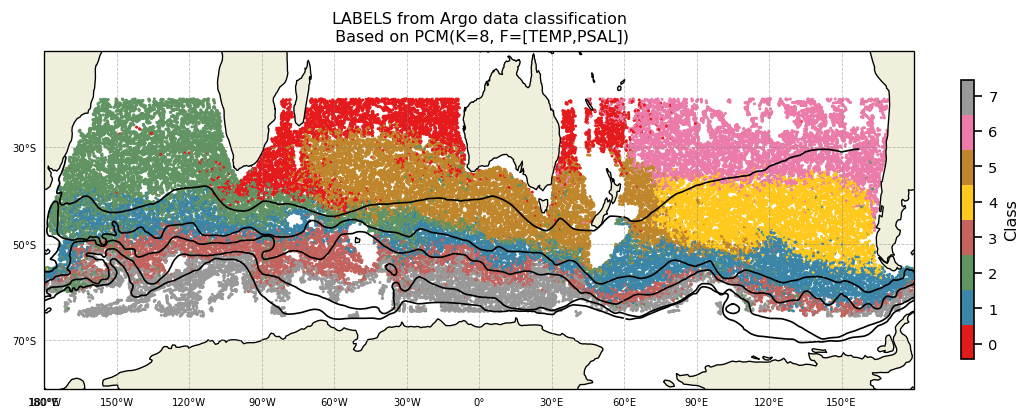

In [14]:
proj = ccrs.PlateCarree(central_longitude=360-60-180)
projref =  ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-180,180,-70,-15]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap(name='Set1')
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=1, c=ds['PCM_LABELS'], cmap=kmap, transform=projref, vmin=0, vmax=m.K)
pyxpcm.plot.colorbar_index(ncolors=m.K, name='Set1', **{**{'fraction':0.015, 'label':'Class'}})

orsi_fronts(ax=ax, transform=projref)
ax.set_aspect(2)
ax.set_extent([-180, 180, -80, -10], projref)
gl = pyxpcm.plot.latlongrid(ax, dx=30, dy=20)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title( "LABELS from Argo data classification\n Based on PCM(K=%i, F=[%s])" %
             (m.K, ",".join([f for f in m.features.keys()])))
plt.show()

This result using K=8 can be compared to Jones et al (2019) analysis based on temperature only data:

<div>
<img src="https://agupubs.onlinelibrary.wiley.com/cms/attachment/625b6ebb-7983-4d03-900f-a6111c6591b8/jgrc23281-fig-0005-m.jpg" width="800"/>
</div>

## Vertical structure of classes

In [15]:
# Compute typical vertical profiles of classes using quantiles:
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

In [16]:
ds

<xarray.Dataset>
Dimensions:             (DEPTH: 302, N_PROF: 62310, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF              (N_PROF) int64 0 1 2 3 4 ... 62306 62307 62308 62309
  * DEPTH               (DEPTH) float32 0.0 -5.0 -10.0 ... -1500.0 -1505.0
    LATITUDE            (N_PROF) float32 -62.167 -62.709 ... -21.79 -20.404
    LONGITUDE           (N_PROF) float32 -178.549 -178.486 ... 178.86 178.979
    TIME                (N_PROF) datetime64[ns] 2009-01-05T08:36:05.624999936 ... 2011-08-13T08:40:18.750000128
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    BRV2                (N_PROF, DEPTH) float32 1.8118634e-07 ... 2.9276048e-06
    DBINDEX             (N_PROF) float64 2.349e+05 2.349e+05 ... 2.268e+05
    PSAL                (N_PROF, DEPTH) float32 33.854 33.854 ... 34.57865
    SIG0                (N_PROF, DEPTH) float32 26.963451 26.963451 ... 27.57429
    TEMP                (N_PROF

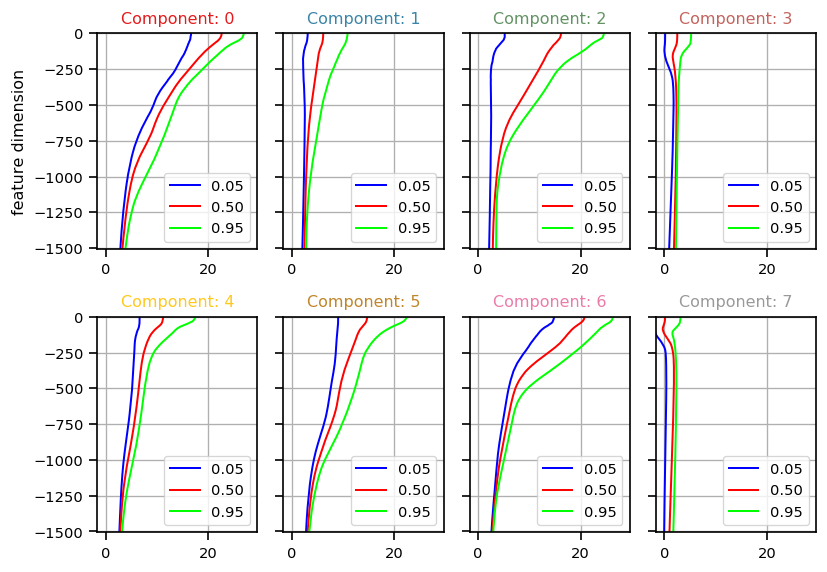

In [17]:
# Plot of vertical profiles:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(7,7), dpi=120, sharey=True)

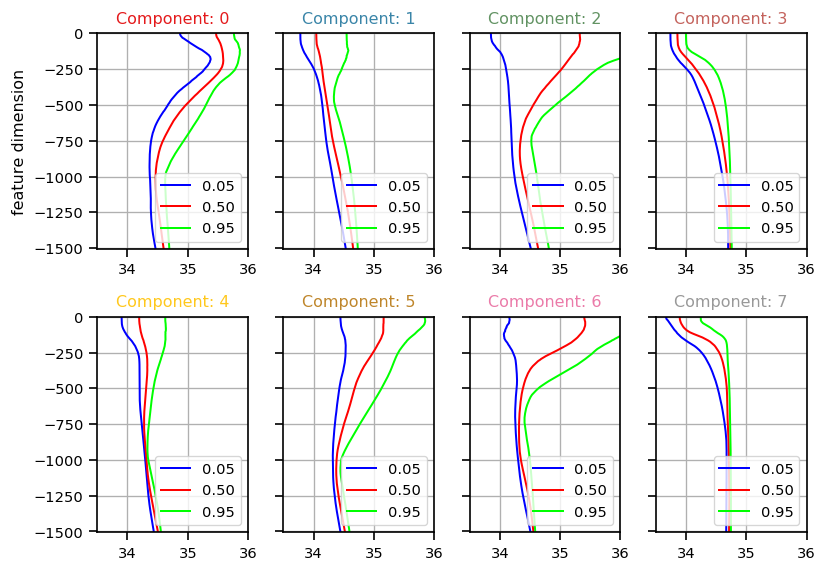

In [18]:
fig, ax = m.plot.quantile(ds['PSAL_Q'], maxcols=4, figsize=(7,7), dpi=120, sharey=True, xlim=[33.5, 36])

## T/S diagram colorcoded by classes

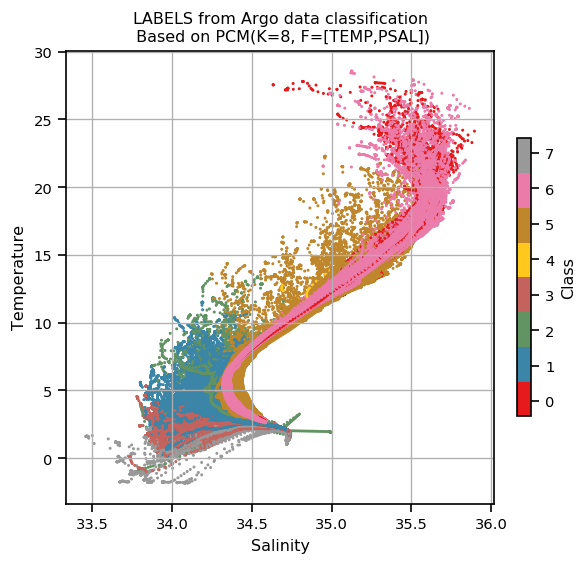

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k')

kmap = m.plot.cmap(name='Set1')
this_ds = ds.isel(N_PROF=np.arange(0,1000)) # Sub-sample to make plot faster and more readable
labels, b = xr.broadcast(this_ds['PCM_LABELS'], this_ds['TEMP'])
ax.scatter(this_ds['PSAL'], this_ds['TEMP'], s=1, c=labels, cmap=kmap, vmin=0, vmax=m.K)
ax.grid(True)
ax.set_ylabel('Temperature')
ax.set_xlabel('Salinity')
pyxpcm.plot.colorbar_index(ncolors=m.K, name='Set1', **{**{'fraction':0.03, 'label':'Class'}})
ax.set_title( "LABELS from Argo data classification\n Based on PCM(K=%i, F=[%s])" %
             (m.K, ",".join([f for f in m.features.keys()])))
plt.show()

# Class robustness

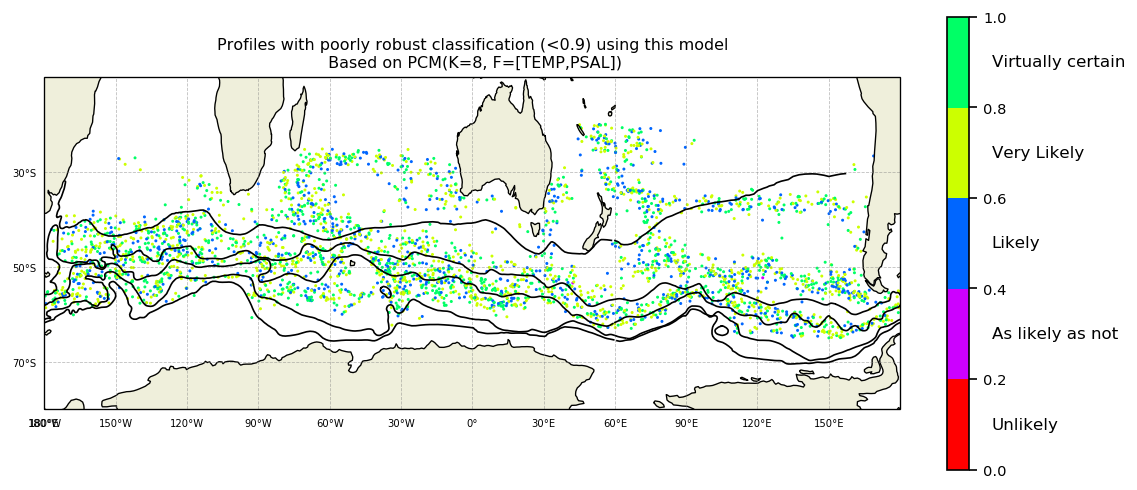

In [20]:
proj = ccrs.PlateCarree(central_longitude=360-60-180)
projref =  ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-180,180,-70,-15]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap(usage='robustness')
this_ds = ds.where(ds['PCM_ROBUSTNESS']<0.9)
sc = ax.scatter(this_ds['LONGITUDE'], this_ds['LATITUDE'], s=1, c=this_ds['PCM_ROBUSTNESS'], cmap=cmap, transform=projref, vmin=0, vmax=1)

boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
cl = plt.colorbar(sc, ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

orsi_fronts(ax=ax, transform=projref)
ax.set_aspect(2)
ax.set_extent([-180, 180, -80, -10], projref)
gl = pyxpcm.plot.latlongrid(ax, dx=30, dy=20)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title( "Profiles with poorly robust classification (<0.9) using this model\n Based on PCM(K=%i, F=[%s])" %
             (m.K, ",".join([f for f in m.features.keys()])))
plt.show()